In [3]:
import cdx_toolkit
import nltk
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/austin.cai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/austin.cai/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austin.cai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stop_words = set(stopwords.words('english'))

cdx = cdx_toolkit.CDXFetcher(source='cc')

In [7]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

In [142]:
# websites from: https://en.wikipedia.org/wiki/Alternative_media_(U.S._political_right)
# 31 items 
right_wing_urls = [
    'www.breitbart.com/*',
    'www.dailywire.com/*',
    'www.theamericanconservative.com/*',
    'www.spectator.org/*',
    'www.theblaze.com/*',
    'www.chroniclesmagazine.org/*',
    'www.cnsnews.com/*',
    'www.commentarymagazine.com/*',
    'www.dailycaller.com/*',
    'www.drudgereport.com/*',
    'www.thefederalist.com/*',
    'www.foxnews.com/*',
    'www.freerepublic.com/*',
    'www.hotair.com/*',
    'www.humanevents.com/*',
    'www.nationalreview.com/*',
    'www.newsmax.com/*',
    'www.nypost.com/*',
    'www.oann.com/*',
    'www.powerlineblog.com/*',
    'www.rd.com/*',
    'www.rebelnews.com/*',
    'www.redstate.com/*',
    'www.sbgi.net/*',
    'www.townhall.com/*',
    'www.wsj.com/*',
    'www.washingtonexaminer.com/*',
    'www.freebeacon.com/*',
    'www.washingtontimes.com/*',
    'www.weeklystandard.com/*',
    'www.wnd.com/*'
]

In [133]:
def html_tag_matcher(tag):
    tag_start_idx = obj.text.find('<{}>'.format(tag))
    tag_end_idx = obj.text.find('</{}>'.format(tag))
    return obj.text[tag_start_idx + len(tag) + 2:tag_end_idx]

def remove_specials(string):
    new_string = remove_special(string)
    while new_string != string:
        string = new_string
        new_string = remove_special(string)
    return new_string

def remove_special(string):
    ampersand_idx = string.find('&')
    if ampersand_idx == -1: return string # if no &, return 
    
    if string[ampersand_idx:ampersand_idx+7].find(';') >= 0:
        semicolon_idx = ampersand_idx + string[ampersand_idx:ampersand_idx+7].find(';')
        return string.replace(string[ampersand_idx:semicolon_idx+1], '')
    else: # if & witout ;, clean substring after &
        return string[:ampersand_idx+1] + remove_special(string[ampersand_idx+1:])

In [134]:
# adapted from: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [143]:
filters = ['=status:200', 'url:hydroxychloroquine']

corpus = []
title_url_list = []
for url in right_wing_urls:
    for obj in cdx.iter(url, limit=500, from_ts='2020', filter=filters):
        if len(html_tag_matcher('title')) > 300: # once in a while, html_tag_matcher returns a huge html blob 
            continue 
        title_url_list.append((remove_specials(html_tag_matcher('title')), obj.data['url']))
        corpus.append(preprocess(html_tag_matcher('title')))

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
retrying after 1s for HTTPSConnectionPool(host='index.commoncrawl.org', port=443): Read timed out. (read timeout=30.0)
None
None
None
None
None
N

In [144]:
corpus, title_url_list = filter_docs(corpus, title_url_list, lambda doc: has_vector_representation(model, doc))
corpus, title_url_list = filter_docs(corpus, title_url_list, lambda doc: (len(doc) != 0))

x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

0 docs removed
0 docs removed


In [152]:
len('''
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
retrying after 1s for HTTPSConnectionPool(host='index.commoncrawl.org', port=443): Read timed out. (read timeout=30.0)
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
retrying after 1s for HTTPSConnectionPool(host='index.commoncrawl.org', port=443): Read timed out. (read timeout=30.0)
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
retrying after 1s for HTTPSConnectionPool(host='index.commoncrawl.org', port=443): Read timed out. (read timeout=30.0)
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
''')/4

665.75

In [145]:
def calc_distance(target, matrix):
    diff = matrix - target
    diff_sqr = np.square(diff)
    return diff_sqr.dot(np.ones(300))

# headlines that explicity claim scientific benifits of Hydroxychloroquine
target = document_vector(model, '''
Doctors say that hydroxychloroquine cures COVID hydroxychloroquine is proven to save lives 
scientific study shows that hydroxychloroquine is safe and cures COVID
Report: Efforts to Remove Dr. Rick Bright Predate Hydroxychloroquine; Incompetence and Insubordination
White House Physician Memo Concludes Hydroxychloroquine Has Potential Benefit
Coronavirus Victim, 52, Said Good-Bye To Family, Prepared to Die; Says Hydroxychloroquine Saved His Life
Dr. Praises Hydroxychloroquine For Coronavirus: ‘Very Ill’ To ‘Basically Symptom Free’ In Hours
LA doctor: COVID-19 patients go from very ill to symptom-free in 8 to 12 hours using hydroxychloroquine and zinc
Michigan Democrat says hydroxychloroquine saved her life
Amy Klobuchar finally admits miracle drug hydroxychloroquine saved her husbands life
That Big Hydroxychloroquine Study the Media Went Nuts Over Turned Out to Be a Scam
Fla. man claims to have been cured of coronavirus after receiving hydroxychloroquine treatment
Doctors report hydroxychloroquine has over 90% chance to cure coronavirus patients
Herring Networks CEO: Hydroxychloroquine has proven to be miraculous
Doctors, Patients recommend Hydroxychloroquine as powerful drug in fight against coronavirus
Hydroxychloroquine rated 'most effective therapy' by doctors for coronavirus: Global survey - Washington Times
Here Are Five People Who Say Hydroxychloroquine Saved Their Lives
''')

distances = calc_distance(target, X)

# headlines that don't explicity claim scientific benifits of Hydroxychloroquine
anti_target = document_vector(model, '''
Alyssa Milano Floats Impeachment over Trump Pushing Hydroxychloroquine
Hollywood Celebs Freak Out After Trump Says Hes Taking Hydroxychloroquine: F**king Moron, Dumb F**k
Watch: WHs Navarro, CNNs Berman Debate Hydroxychloroquine -- God Help It If You Get COVID
Biden Campaign Advisor: Prosecute Trump For ‘Crimes Against Humanity’ For Endorsing Hydroxychloroquine To Fight Virus
VA secretary vows to continue offering hydroxychloroquine to veterans
FDA pulls emergency use authorization for hydroxychloroquine
Democrats Plan to Censure, Withhold Endorsements for State Rep Who Claimed That Hydroxychloroquine Saved Her Life
Trump Reveals He Is Taking Hydroxychloroquine As Preventative Measure
President Trump Says He Is Taking Hydroxychloroquine
''')

anti_distances = calc_distance(anti_target, X)

In [146]:
low_distance_idxs = set()
for i, distance in enumerate(distances):
    if distance < np.quantile(distances, 0.6):
        low_distance_idxs.add(i)
  
low_anti_distance_idxs = set()
for i, distance in enumerate(anti_distances):
    if distance < np.quantile(anti_distances, 0.25):
        low_anti_distance_idxs.add(i)

In [147]:
fake_news_title_url_list = []

for idx in low_distance_idxs:
    if idx not in low_anti_distance_idxs:
        fake_news_title_url_list.append(title_url_list[idx])

In [148]:
with open("fake-hydroxychloroquine-urls", "w") as f:
    for title_url in fake_news_title_url_list:
        print(title_url[0])
        f.write("{}\n".format(title_url[1]))

Alyssa Milano Floats Impeachment over Trump Pushing Hydroxychloroquine
Report: Efforts to Remove Dr. Rick Bright Predate Hydroxychloroquine; Incompetence and Insubordination
White House Physician Memo Concludes Hydroxychloroquine Has Potential Benefit
Robert Wilkie Blasts Phony Media on Hydroxychloroquine Study
Donald Trump Sending Brazil 1,000 Ventilators; 2 Million Doses of Hydroxychloroquine
Donald Trump Sending Brazil 1,000 Ventilators; 2 Million Doses of Hydroxychloroquine
Donald Trump Sending Brazil 1,000 Ventilators; 2 Million Doses of Hydroxychloroquine
Brzezinski on Trump Pushing Hydroxychloroquine: Theres Got to Be Some Sort of Financial Tie
AG Barr: Media Have Been on a Jihad to Discredit Hydroxychloroquine
AG Barr: Media Have Been on a Jihad to Discredit Hydroxychloroquine
Pelosi: Not a Good Idea for Morbidly Obese Trump to Take Hydroxychloroquine
Scarborough: Let Me Assure You Trump Isnt Taking Hydroxychloroquine -- Its a Distraction
Schumer: Trump Saying He Has Been Takin

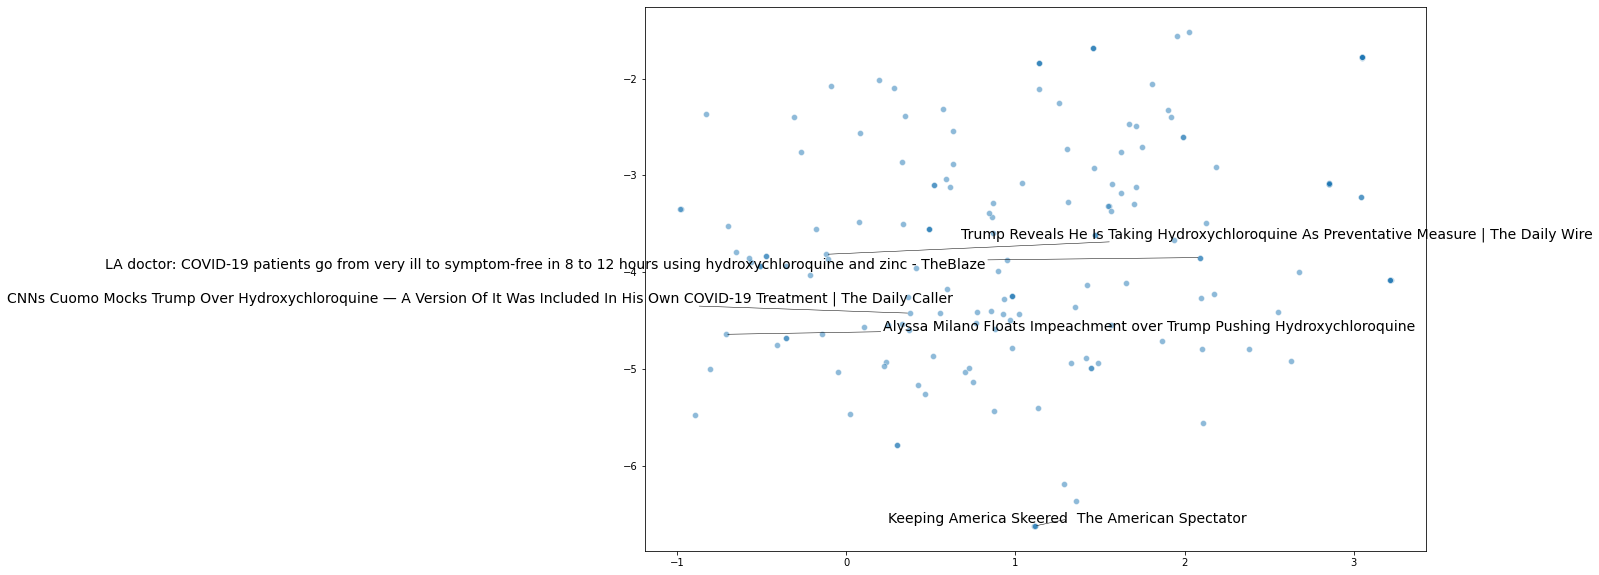

In [49]:
# visualization for data exploration, not used in actual solution 
# adapted from: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

import adjustText
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 50, 10)) # plots every 40th title in first 400 titles

# Append words to list
titles_list = [title_url[0] for title_url in title_url_list]
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()